In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
import seaborn as sns
from gtfparse import read_gtf
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles
import bioframe
import warnings
warnings.filterwarnings('ignore')
import random
from scipy.stats import zscore, spearmanr, mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

## DEGs

In [3]:
# Read GTF with gene annotation
genes = read_gtf('/DATA/users/magnitov/genomes/gencode.vM25.annotation.gtf')
genes = genes[genes['feature'] == 'gene']
genes = genes[['seqname', 'start', 'end', 'strand', 'gene_id', 'gene_type', 'gene_name']]
genes.head()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'mgi_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'protein_id', 'ccdsid', 'ont']


,seqname,start,end,strand,gene_id,gene_type,gene_name
0,chr1,3073253,3074322,+,ENSMUSG00000102693.1,TEC,4933401J01Rik
3,chr1,3102016,3102125,+,ENSMUSG00000064842.1,snRNA,Gm26206
6,chr1,3205901,3671498,-,ENSMUSG00000051951.5,protein_coding,Xkr4
24,chr1,3252757,3253236,+,ENSMUSG00000102851.1,processed_pseudogene,Gm18956
27,chr1,3365731,3368549,-,ENSMUSG00000103377.1,TEC,Gm37180


### IAA 6H vs DMSO

In [4]:
degs_6H = pd.read_csv('./degs/degs_6H_RAD21_DESeq.csv', sep = '\s+', header = 0)
degs_6H['gene_id'] = degs_6H.index
degs_6H.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSMUSG00000103922.1,68.614895,-0.105932,0.335767,-0.315494,0.752387,0.999957,ENSMUSG00000103922.1
ENSMUSG00000033845.13,2811.973373,-0.028014,0.109409,-0.256053,0.797910,0.999957,ENSMUSG00000033845.13
ENSMUSG00000102275.1,10.974871,-0.882308,0.797857,-1.105847,0.268793,NaN,ENSMUSG00000102275.1
ENSMUSG00000025903.14,1108.832655,-0.100446,0.162771,-0.617100,0.537169,0.999957,ENSMUSG00000025903.14
ENSMUSG00000033813.15,677.892270,-0.101074,0.175834,-0.574826,0.565409,0.999957,ENSMUSG00000033813.15


In [5]:
degs_6H = degs_6H.merge(genes, on = 'gene_id')

columns_to_save = ['seqname', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
degs_6H = degs_6H[columns_to_save]

degs_6H.sort_values('log2FoldChange').head()

,seqname,start,end,gene_name,gene_id,strand,gene_type,log2FoldChange,baseMean,pvalue,padj
10734,chr14,121248706,121253971,B930095G15Rik,ENSMUSG00000085133.2,+,sense_intronic,-2.586470,8.485880,1.535462e-02,NaN
10282,chr13,114452290,114458951,Fst,ENSMUSG00000021765.9,-,protein_coding,-2.500372,53.922227,1.390068e-10,8.006792e-08
4495,chr6,79032044,79035869,Gm20362,ENSMUSG00000108072.1,+,lincRNA,-2.280696,9.961733,1.918346e-02,NaN
411,chr1,119415465,119422248,Inhbb,ENSMUSG00000037035.5,-,protein_coding,-2.245535,19.137668,7.382650e-04,NaN
7270,chr9,105989454,106096783,Col6a4,ENSMUSG00000032572.9,-,protein_coding,-2.154324,36.331589,2.791358e-03,1.045333e-01


In [6]:
degs_6H_up = degs_6H[(degs_6H['padj'] < 0.01) & (degs_6H['log2FoldChange'] > 0)]
degs_6H_down = degs_6H[(degs_6H['padj'] < 0.01) & (degs_6H['log2FoldChange'] < 0)]
degs_6H_stable = degs_6H[~degs_6H['gene_id'].isin([x for x in degs_6H['gene_id'].values \
                                                   if x in degs_6H_down['gene_id'].values or x in degs_6H_up['gene_id'].values])]

print('Up-regulated:', len(degs_6H_up))
print('Down-regulated:', len(degs_6H_down))
print('No change:', len(degs_6H_stable))
print('Low expression:', len(genes) - len(degs_6H))

Up-regulated: 45
Down-regulated: 85
No change: 13559
Low expression: 41712


In [7]:
degs_6H_down['direction'] = ['down']*len(degs_6H_down)
degs_6H_up['direction'] = ['up']*len(degs_6H_up)
degs_6H_stable['direction'] = ['stable']*len(degs_6H_stable)

### IAA 24H vs DMSO

In [8]:
degs_24H = pd.read_csv('./degs/degs_24H_RAD21_DESeq.csv', sep = '\s+', header = 0)
degs_24H['gene_id'] = degs_24H.index
degs_24H.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSMUSG00000103922.1,68.614895,-0.621759,0.343299,-1.811128,0.070121,0.172419,ENSMUSG00000103922.1
ENSMUSG00000033845.13,2811.973373,-0.420618,0.109802,-3.830678,0.000128,0.000894,ENSMUSG00000033845.13
ENSMUSG00000102275.1,10.974871,-0.295260,0.765171,-0.385874,0.699590,0.829265,ENSMUSG00000102275.1
ENSMUSG00000025903.14,1108.832655,0.617707,0.161230,3.831226,0.000128,0.000892,ENSMUSG00000025903.14
ENSMUSG00000033813.15,677.892270,-0.617015,0.177297,-3.480116,0.000501,0.002940,ENSMUSG00000033813.15


In [9]:
degs_24H = degs_24H.merge(genes, on = 'gene_id')

columns_to_save = ['seqname', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
degs_24H = degs_24H[columns_to_save]

degs_24H.sort_values('log2FoldChange').head()

,seqname,start,end,gene_name,gene_id,strand,gene_type,log2FoldChange,baseMean,pvalue,padj
5731,chr7,119140747,119184603,Gpr139,ENSMUSG00000066197.5,-,protein_coding,-5.195064,17.761798,1.125729e-05,1.023758e-04
8513,chr11,66911981,66929876,Pirt,ENSMUSG00000048070.4,+,protein_coding,-4.691687,11.564213,1.496847e-04,1.024066e-03
1316,chr2,119351229,119354381,Chac1,ENSMUSG00000027313.3,+,protein_coding,-4.261903,145.695542,6.062530e-29,6.838432e-27
861,chr2,25291181,25319187,Grin1,ENSMUSG00000026959.13,-,protein_coding,-3.670369,121.912911,1.246523e-19,6.460262e-18
9074,chr11,107874605,107915055,Cacng5,ENSMUSG00000040373.12,-,protein_coding,-3.445060,24.111389,5.173875e-05,3.998211e-04


In [10]:
degs_24H_up = degs_24H[(degs_24H['padj'] < 0.01) & (degs_24H['log2FoldChange'] > 0)]
degs_24H_down = degs_24H[(degs_24H['padj'] < 0.01) & (degs_24H['log2FoldChange'] < 0)]
degs_24H_stable = degs_24H[~degs_24H['gene_id'].isin([x for x in degs_24H['gene_id'].values \
                                                      if x in degs_24H_down['gene_id'].values or x in degs_24H_up['gene_id'].values])]

print('Up-regulated:', len(degs_24H_up))
print('Down-regulated:', len(degs_24H_down))
print('No change:', len(degs_24H_stable))
print('Low expression:', len(genes) - len(degs_24H))

Up-regulated: 1527
Down-regulated: 1295
No change: 10867
Low expression: 41712


In [11]:
degs_24H_down['direction'] = ['down']*len(degs_24H_down)
degs_24H_up['direction'] = ['up']*len(degs_24H_up)
degs_24H_stable['direction'] = ['stable']*len(degs_24H_stable)

## Volcano plots

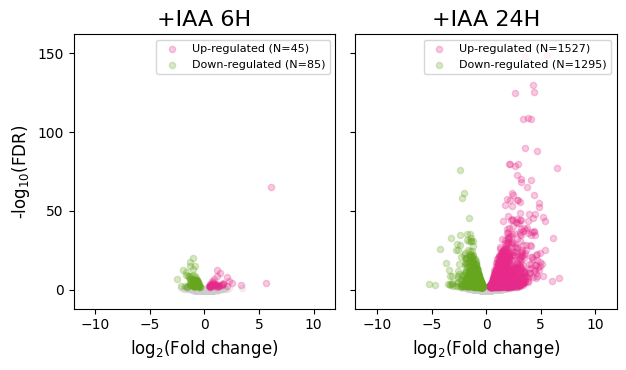

In [12]:
plt.figure(figsize = (12, 3.8))

plt.subplot(141)
plt.title('+IAA 6H', fontsize = 16)
plt.scatter(degs_6H_stable['log2FoldChange'], -np.log10(degs_6H_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(degs_6H_up['log2FoldChange'], -np.log10(degs_6H_up['padj']), 
            color = '#E72A8A', label = f'Up-regulated (N={len(degs_6H_up)})', alpha = 0.25, s = 20)
plt.scatter(degs_6H_down['log2FoldChange'], -np.log10(degs_6H_down['padj']), 
            color = '#66A61E', label = f'Down-regulated (N={len(degs_6H_down)})', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 12)
plt.ylabel('-log$_{10}$(FDR)', fontsize = 12)
plt.xlim((-12, 12))
plt.ylim((-12, 162))
plt.yticks([0, 50, 100, 150], [0, 50, 100, 150])
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(142)
plt.title('+IAA 24H', fontsize = 16)
plt.scatter(degs_24H_stable['log2FoldChange'], -np.log10(degs_24H_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(degs_24H_up['log2FoldChange'], -np.log10(degs_24H_up['padj']), 
            color = '#E72A8A', label = f'Up-regulated (N={len(degs_24H_up)})', alpha = 0.25, s = 20)
plt.scatter(degs_24H_down['log2FoldChange'], -np.log10(degs_24H_down['padj']), 
            color = '#66A61E', label = f'Down-regulated (N={len(degs_24H_down)})', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 12)
plt.xlim((-12, 12))
plt.ylim((-12, 162))
plt.yticks([0, 50, 100, 150], [])
plt.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()
plt.show()

## DEGs overlap with plumes

In [13]:
genes = read_gtf('/DATA/users/magnitov/genomes/gencode.vM25.annotation.gtf')
genes = genes[genes['feature'] == 'gene']
genes = genes[['seqname', 'start', 'end', 'strand', 'gene_id', 'gene_type', 'gene_name']]
genes.columns = ['chrom', 'start', 'end', 'strand', 'gene_id', 'gene_type', 'gene_name']
not_expressed_genes = genes[~genes['gene_id'].isin(degs_6H['gene_id'].values)]['gene_id'].values

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'mgi_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'protein_id', 'ccdsid', 'ont']


In [14]:
distance_from_plume_base = 100000

In [15]:
plumes_fontanka = pd.read_csv('fountains_fontanka_merged.bed', sep = '\t', header = None)
plumes_fontanka.columns = ['chrom', 'start', 'end']
plumes_fontanka['start'] = plumes_fontanka['start'] - distance_from_plume_base
plumes_fontanka['end'] = plumes_fontanka['end'] + distance_from_plume_base
plumes_fontanka.head()

,chrom,start,end
0,chr1,6960000,7180000
1,chr1,11280000,11500000
2,chr1,15640000,15860000
3,chr1,20840000,21060000
4,chr1,23860000,24080000


In [16]:
genes_overlapping_plumes = bioframe.overlap(genes, plumes_fontanka, suffixes=('','_tacl_domain'))
genes_overlapping_plumes = genes_overlapping_plumes[~genes_overlapping_plumes['gene_id'].isin(not_expressed_genes)]

genes_inside_plumes = genes_overlapping_plumes.dropna()['gene_id'].values
genes_inside_plumes = np.unique(genes_inside_plumes)
genes_outside_plumes = genes_overlapping_plumes[genes_overlapping_plumes.isnull().any(axis=1)]['gene_id'].values
genes_outside_plumes = np.unique(genes_outside_plumes)

len(genes_outside_plumes), len(genes_inside_plumes)

(11972, 1717)

In [17]:
degs_6H = pd.concat([degs_6H_down, degs_6H_up, degs_6H_stable])
degs_24H = pd.concat([degs_24H_down, degs_24H_up, degs_24H_stable])

In [20]:
shuffled_fractions_6H, shuffled_fractions_24H = [], []

for i in range(100):
    degs_6H['direction_shuffled'] = random.sample(list(degs_6H['direction'].values), len(degs_6H))
    plume_degs_6H = pd.DataFrame([[len([x for x in degs_6H[degs_6H['direction_shuffled'] == 'down']['gene_id'].values if x in genes_inside_plumes]),
                                   len([x for x in degs_6H[degs_6H['direction_shuffled'] == 'up']['gene_id'].values if x in genes_inside_plumes]),
                                   len([x for x in degs_6H[degs_6H['direction_shuffled'] == 'stable']['gene_id'].values if x in genes_inside_plumes])],
                                  [len([x for x in degs_6H[degs_6H['direction_shuffled'] == 'down']['gene_id'].values if x in genes_outside_plumes]),
                                   len([x for x in degs_6H[degs_6H['direction_shuffled'] == 'up']['gene_id'].values if x in genes_outside_plumes]),
                                   len([x for x in degs_6H[degs_6H['direction_shuffled'] == 'stable']['gene_id'].values if x in genes_outside_plumes])]],
                                  columns = ['Down-regulated', 'Up-regulated', 'Stable'], index = ['Plume', 'Other']).transpose()
    fractions_degs_6H = [plume_degs_6H['Plume'].values[0]/(plume_degs_6H['Plume'].values[0] + plume_degs_6H['Other'].values[0]),
                         plume_degs_6H['Plume'].values[1]/(plume_degs_6H['Plume'].values[1] + plume_degs_6H['Other'].values[1]),
                         plume_degs_6H['Plume'].values[2]/(plume_degs_6H['Plume'].values[2] + plume_degs_6H['Other'].values[2])]
    shuffled_fractions_6H.append(fractions_degs_6H)

    degs_24H['direction_shuffled'] = random.sample(list(degs_24H['direction'].values), len(degs_24H))
    plume_degs_24H = pd.DataFrame([[len([x for x in degs_24H[degs_24H['direction_shuffled'] == 'down']['gene_id'].values if x in genes_inside_plumes]),
                                    len([x for x in degs_24H[degs_24H['direction_shuffled'] == 'up']['gene_id'].values if x in genes_inside_plumes]),
                                    len([x for x in degs_24H[degs_24H['direction_shuffled'] == 'stable']['gene_id'].values if x in genes_inside_plumes])],
                                   [len([x for x in degs_24H[degs_24H['direction_shuffled'] == 'down']['gene_id'].values if x in genes_outside_plumes]),
                                    len([x for x in degs_24H[degs_24H['direction_shuffled'] == 'up']['gene_id'].values if x in genes_outside_plumes]),
                                    len([x for x in degs_24H[degs_24H['direction_shuffled'] == 'stable']['gene_id'].values if x in genes_outside_plumes])]],
                                   columns = ['Down-regulated', 'Up-regulated', 'Stable'], index = ['Plume', 'Other']).transpose()
    fractions_degs_24H = [plume_degs_24H['Plume'].values[0]/(plume_degs_24H['Plume'].values[0] + plume_degs_24H['Other'].values[0]),
                          plume_degs_24H['Plume'].values[1]/(plume_degs_24H['Plume'].values[1] + plume_degs_24H['Other'].values[1]),
                          plume_degs_24H['Plume'].values[2]/(plume_degs_24H['Plume'].values[2] + plume_degs_24H['Other'].values[2])]
    shuffled_fractions_24H.append(fractions_degs_24H)

In [21]:
mean_shuffled_fractions_6H = np.mean(shuffled_fractions_6H, axis = 0)
min_shuffled_fractions_6H = np.min(shuffled_fractions_6H, axis = 0)
max_shuffled_fractions_6H = np.max(shuffled_fractions_6H, axis = 0)

mean_shuffled_fractions_24H = np.mean(shuffled_fractions_24H, axis = 0)
min_shuffled_fractions_24H = np.min(shuffled_fractions_24H, axis = 0)
max_shuffled_fractions_24H = np.max(shuffled_fractions_24H, axis = 0)

print(mean_shuffled_fractions_6H, min_shuffled_fractions_6H, max_shuffled_fractions_6H)
print(mean_shuffled_fractions_24H, min_shuffled_fractions_24H, max_shuffled_fractions_24H)

[0.12270588 0.12577778 0.12544509] [0.04705882 0.04444444 0.12464046] [0.2        0.26666667 0.1261155 ]
[0.12511969 0.12714473 0.12522499] [0.1042471  0.10805501 0.12082451] [0.14285714 0.14734774 0.12864636]


In [25]:
plume_degs_6H = pd.DataFrame([[len([x for x in degs_6H[degs_6H['direction'] == 'down']['gene_id'].values if x in genes_inside_plumes]),
                               len([x for x in degs_6H[degs_6H['direction'] == 'up']['gene_id'].values if x in genes_inside_plumes]),
                               len([x for x in degs_6H[degs_6H['direction'] == 'stable']['gene_id'].values if x in genes_inside_plumes])],
                              [len([x for x in degs_6H[degs_6H['direction'] == 'down']['gene_id'].values if x in genes_outside_plumes]),
                               len([x for x in degs_6H[degs_6H['direction'] == 'up']['gene_id'].values if x in genes_outside_plumes]),
                               len([x for x in degs_6H[degs_6H['direction'] == 'stable']['gene_id'].values if x in genes_outside_plumes])]],
                              columns = ['Down-regulated', 'Up-regulated', 'Stable'], index = ['Plume', 'Other']).transpose()

plume_degs_24H = pd.DataFrame([[len([x for x in degs_24H[degs_24H['direction'] == 'down']['gene_id'].values if x in genes_inside_plumes]),
                                len([x for x in degs_24H[degs_24H['direction'] == 'up']['gene_id'].values if x in genes_inside_plumes]),
                                len([x for x in degs_24H[degs_24H['direction'] == 'stable']['gene_id'].values if x in genes_inside_plumes])],
                               [len([x for x in degs_24H[degs_24H['direction'] == 'down']['gene_id'].values if x in genes_outside_plumes]),
                                len([x for x in degs_24H[degs_24H['direction'] == 'up']['gene_id'].values if x in genes_outside_plumes]),
                                len([x for x in degs_24H[degs_24H['direction'] == 'stable']['gene_id'].values if x in genes_outside_plumes])]],
                               columns = ['Down-regulated', 'Up-regulated', 'Stable'], index = ['Plume', 'Other']).transpose()

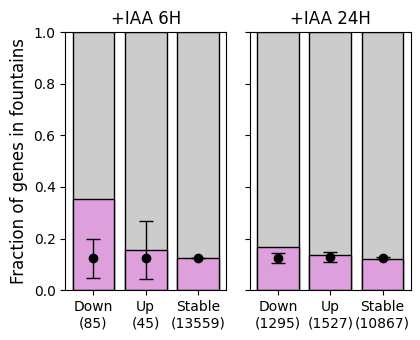

In [26]:
plt.figure(figsize = (8, 3.5))

plt.subplot(141)
plt.title('+IAA 6H')
plt.bar([0, 1, 2], [1, 1, 1], color = '#CCCCCC', edgecolor = 'k', lw = 1)
plt.bar([0, 1, 2], [plume_degs_6H['Plume'].values[0]/(plume_degs_6H['Plume'].values[0] + plume_degs_6H['Other'].values[0]),
                    plume_degs_6H['Plume'].values[1]/(plume_degs_6H['Plume'].values[1] + plume_degs_6H['Other'].values[1]),
                    plume_degs_6H['Plume'].values[2]/(plume_degs_6H['Plume'].values[2] + plume_degs_6H['Other'].values[2])],
        edgecolor = 'k', lw = 1, color = 'plum')
plt.errorbar([0, 1, 2], mean_shuffled_fractions_6H, yerr = (mean_shuffled_fractions_6H-min_shuffled_fractions_6H, 
                                                            max_shuffled_fractions_6H-mean_shuffled_fractions_6H), 
             capsize = 5, zorder = 3, fmt = 'o',  color = 'k', lw = 1)
plt.xticks([0, 1, 2], ['Down\n(' + str(np.sum(plume_degs_6H.values[0])) + ')', 
                       'Up\n(' + str(np.sum(plume_degs_6H.values[1])) + ')', 
                       'Stable\n(' + str(np.sum(plume_degs_6H.values[2])) + ')'])
plt.ylabel('Fraction of genes in fountains', fontsize = 12)
plt.ylim((0, 1))

plt.subplot(142)
plt.title('+IAA 24H')
plt.bar([0, 1, 2], [1, 1, 1], color = '#CCCCCC', edgecolor = 'k', lw = 1)
plt.bar([0, 1, 2], [plume_degs_24H['Plume'].values[0]/(plume_degs_24H['Plume'].values[0] + plume_degs_24H['Other'].values[0]),
                    plume_degs_24H['Plume'].values[1]/(plume_degs_24H['Plume'].values[1] + plume_degs_24H['Other'].values[1]),
                    plume_degs_24H['Plume'].values[2]/(plume_degs_24H['Plume'].values[2] + plume_degs_24H['Other'].values[2])],
        edgecolor = 'k', lw = 1, color = 'plum')
plt.errorbar([0, 1, 2], mean_shuffled_fractions_24H, yerr = (mean_shuffled_fractions_24H-min_shuffled_fractions_24H, 
                                                             max_shuffled_fractions_24H-mean_shuffled_fractions_24H), 
             capsize = 5, zorder = 3, fmt = 'o',  color = 'k', lw = 1)
plt.xticks([0, 1, 2], ['Down\n(' + str(np.sum(plume_degs_24H.values[0])) + ')', 
                       'Up\n(' + str(np.sum(plume_degs_24H.values[1])) + ')', 
                       'Stable\n(' + str(np.sum(plume_degs_24H.values[2])) + ')'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [])
plt.ylim((0, 1))

plt.tight_layout()
plt.show()